<a href="https://colab.research.google.com/github/FernandoCerriteno/Portafolio-TC3007C.502/blob/main/Deep%20Learning/Identificacion_Obj_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Librerias

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from keras.src.engine.data_adapter import train_validation_split

Procesamiento de los datos

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160,160)
PATH = '/content/drive/MyDrive/Images/computer_parts'

train_dir = os.path.join(PATH, 'train')

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle = True,
                                                            batch_size = BATCH_SIZE,
                                                            image_size = IMG_SIZE)

test_dir = os.path.join(PATH, 'test')

test_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle = True,
                                                            batch_size = BATCH_SIZE,
                                                            image_size = IMG_SIZE)

Found 853 files belonging to 3 classes.
Found 853 files belonging to 3 classes.


In [ ]:
train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

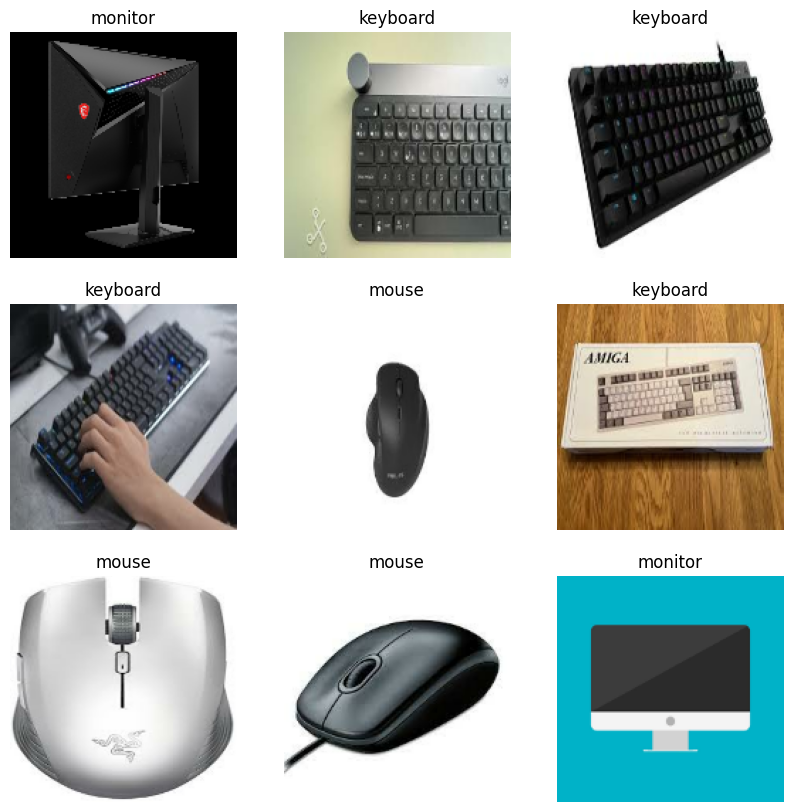

In [ ]:
class_name = train_dataset.class_names

plt.figure(figsize = (10,10))
for image, label in train_dataset.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(class_name[label[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(train_dataset)
test_batches = tf.data.experimental.cardinality(test_dataset)
validation_dataset = train_dataset.skip(val_batches // 5)

print('Numero de batches para validation_dataset = %d' % tf.data.experimental.cardinality(validation_dataset))
print('Numero de batches para test_dataset = %d' % test_batches)

Numero de batches para validation_dataset = 22
Numero de batches para test_dataset = 27


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

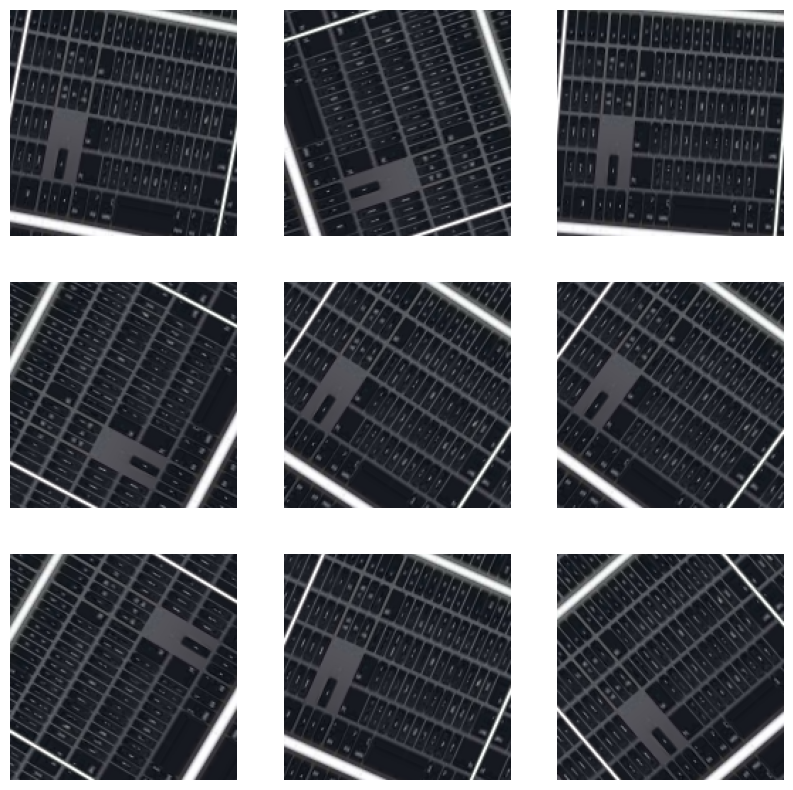

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  first_image = image[0]
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    augmented_image = data_augmentation(tf.expand_dims(first_image,0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis("off")

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Cargar la red pre-entrenada DenseNet121

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)
base_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

(160, 160, 3)


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

print(feature_batch.shape)

(32, 5, 5, 1024)


In [ ]:
base_model.trainable = False
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 zero_padding2d_14 (ZeroPad  (None, 166, 166, 3)          0         ['input_15[0][0]']            
 ding2D)                                                                                          
                                                                                                  
 conv1/conv (Conv2D)         (None, 80, 80, 64)           9408      ['zero_padding2d_14[0][0]']   
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 80, 80, 64)           256       ['conv1/conv[0][0]']

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1024)


In [ ]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


Unir modelo

In [ ]:
inputs = tf.keras.Input(shape=(160,160,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_7 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_7 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 densenet121 (Functional)    (None, 5, 5, 1024)        7037504   
                                                                 
 global_average_pooling2d_7  (None, 1024)              0   

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print(loss0)
print(accuracy0)

22/22 [==============================] - 11s 187ms/step - loss: 0.9614 - accuracy: 0.6537
0.9613553881645203
0.6536796689033508


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data = validation_dataset)

Epoch 1/10
27/27 [==============================] - 17s 291ms/step - loss: 0.9987 - accuracy: 0.6237 - val_loss: 0.6455 - val_accuracy: 0.7359
Epoch 2/10
27/27 [==============================] - 10s 318ms/step - loss: 0.8429 - accuracy: 0.6542 - val_loss: 0.5013 - val_accuracy: 0.8124
Epoch 3/10
27/27 [==============================] - 10s 331ms/step - loss: 0.6840 - accuracy: 0.7140 - val_loss: 0.4281 - val_accuracy: 0.8384
Epoch 4/10
27/27 [==============================] - 9s 296ms/step - loss: 0.5972 - accuracy: 0.7655 - val_loss: 0.3529 - val_accuracy: 0.8846
Epoch 5/10
27/27 [==============================] - 10s 302ms/step - loss: 0.4846 - accuracy: 0.8159 - val_loss: 0.3126 - val_accuracy: 0.9091
Epoch 6/10
27/27 [==============================] - 10s 332ms/step - loss: 0.4618 - accuracy: 0.8242 - val_loss: 0.2804 - val_accuracy: 0.9235
Epoch 7/10
27/27 [==============================] - 10s 320ms/step - loss: 0.4391 - accuracy: 0.8406 - val_loss: 0.2438 - val_accuracy: 0.9394


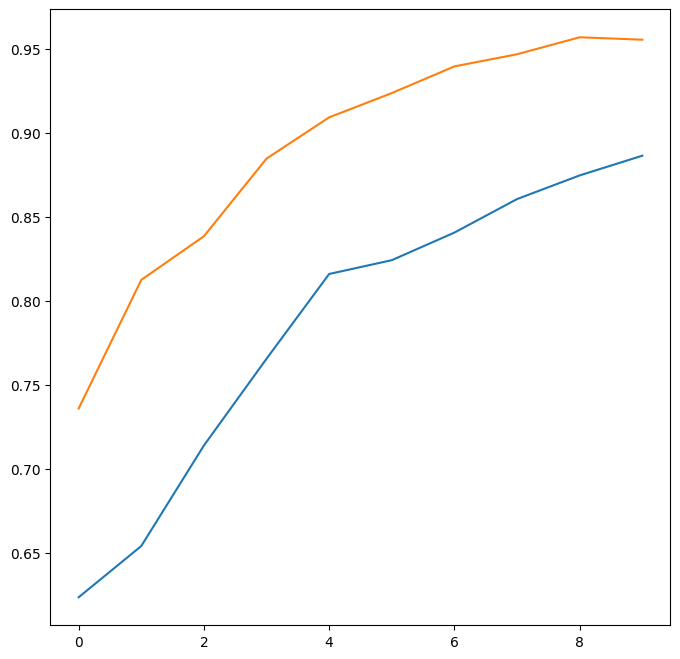

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(8,8))
plt.plot(acc, label = 'Training acc')
plt.plot(val_acc, label = 'Validation acc')

Fine tunning

In [ ]:
base_model.trainable = True

print('Numero de capas ', len(base_model.layers))

Numero de capas  427


In [ ]:
fine_tune_at=100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_7 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_7 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 densenet121 (Functional)    (None, 5, 5, 1024)        7037504   
                                                                 
 global_average_pooling2d_7  (None, 1024)              0   

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit (train_dataset,
                          epochs = total_epochs,
                          initial_epoch = history.epoch[-1],
                          validation_data=validation_dataset)

Epoch 10/20
27/27 [==============================] - 55s 511ms/step - loss: 0.5351 - accuracy: 0.8581 - val_loss: 0.0598 - val_accuracy: 0.9827
Epoch 11/20
27/27 [==============================] - 11s 374ms/step - loss: 0.1131 - accuracy: 0.9613 - val_loss: 0.0222 - val_accuracy: 0.9942
Epoch 12/20
27/27 [==============================] - 10s 347ms/step - loss: 0.0662 - accuracy: 0.9730 - val_loss: 0.0385 - val_accuracy: 0.9856
Epoch 13/20
27/27 [==============================] - 11s 367ms/step - loss: 0.0916 - accuracy: 0.9707 - val_loss: 0.0054 - val_accuracy: 0.9986
Epoch 14/20
27/27 [==============================] - 11s 375ms/step - loss: 0.1060 - accuracy: 0.9730 - val_loss: 0.0230 - val_accuracy: 0.9928
Epoch 15/20
27/27 [==============================] - 11s 348ms/step - loss: 0.0595 - accuracy: 0.9812 - val_loss: 0.1460 - val_accuracy: 0.9437
Epoch 16/20
27/27 [==============================] - 11s 361ms/step - loss: 0.0889 - accuracy: 0.9801 - val_loss: 0.0089 - val_accuracy:

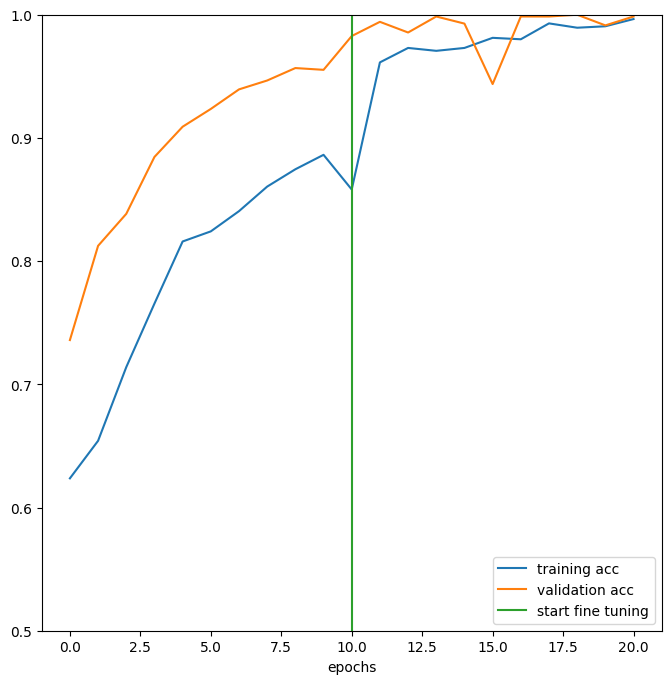

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

plt.figure(figsize=(8,8))
plt.plot(acc, label = 'training acc')
plt.plot(val_acc, label = 'validation acc')
plt.ylim([0.5, 1])
plt.plot([initial_epochs, initial_epochs],
         plt.ylim(), label='start fine tuning')

plt.legend(loc='lower right')
plt.xlabel('epochs')
plt.show()

In [ ]:
model.save('model.h5')

27/27 [==============================] - 6s 176ms/step


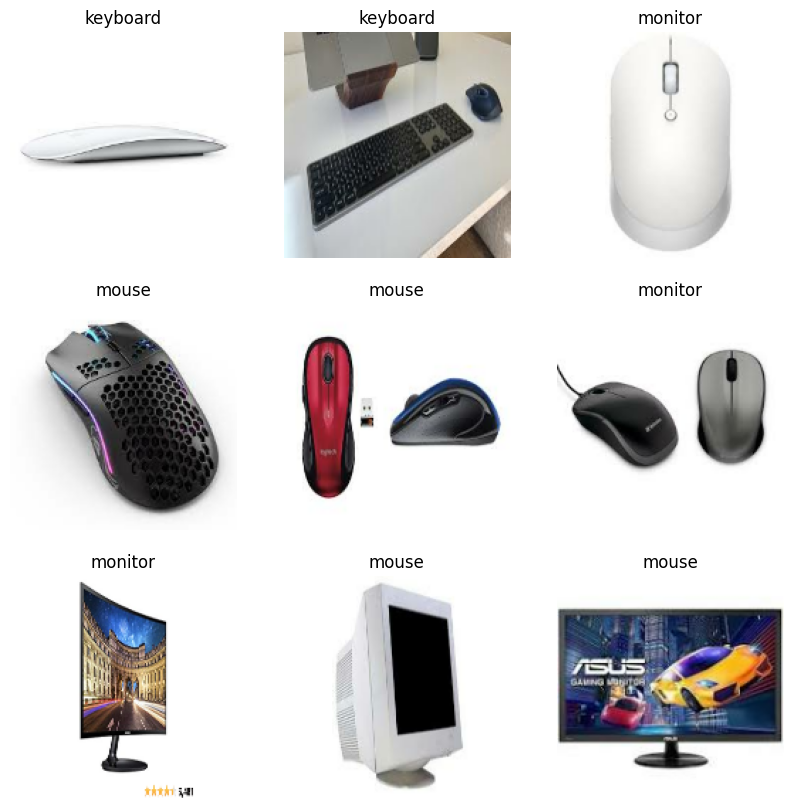

In [ ]:
predictions = model.predict(test_dataset)

# class_name = train_dataset.class_names

plt.figure(figsize = (10,10))
for image, label in train_dataset.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(class_name[np.argmax(predictions[i])])
    plt.axis("off")